# Import an Xspec save file and create images of the model

We need to load the save file with pyxspec, then retrieve information from the xspec.AllData and xspec.AllModels objects.

The model parameters of the background components must be interpreted in tandem with their addmodel_* functions for consistency. Because we are building spectral and imaging products for these background components only, we will not consider any additional model components added by the user, who may need those to account for excess emission.

The user is supposed to not modify the loaded data files and existing model components (except their parameter values). For the spectral data files especially, their order must be preserved because this is used to match with their respective region files from bgdinfo.json. The loaded save file should then retain that same order for xspec.AllData.

_This first part is the same as reading the save file for nuskybgd spec._

In [1]:
import xspec
import json
import os
import astropy.io.fits as pf
import numpy as np
import nuskybgd
import nuskybgd.model as numodel
from nuskybgd import util
from nuskybgd import conf

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

In [2]:
# Mac
savefile = 'IC342bgd.xcm'
nustardir = '/Users/qw/astro/nustar'
specdir = nustardir + '/IC342_X1/90201039002/event_cl/spec'
bgddir = nustardir + '/IC342_X1/90201039002/event_cl/bgd'

In [178]:
os.chdir(bgddir)
xspec.AllData.clear()
xspec.Xset.restore(savefile)

In [179]:
for i in range(xspec.AllData.nSpectra):
    spec = xspec.AllData(i + 1)
    print(spec.fileName)

bgd1A_sr_g30.pha
bgd1B_sr_g30.pha
bgd2A_sr_g30.pha
bgd2B_sr_g30.pha
bgd3A_sr_g30.pha
bgd3B_sr_g30.pha


In [181]:
bgdinfo = numodel.check_bgdinfofile('bgdinfo.json')

if bgdinfo is not False:
    # bgfiles and regfiles must have the same ordering
    bgfiles = bgdinfo['bgfiles']
    regfiles = bgdinfo['regfiles']
    refimgf = bgdinfo['refimgf']
    bgdapfiles = bgdinfo['bgdapfiles']
    bgddetfiles = bgdinfo['bgddetfiles']

    bgdapim = {}
    bgdapim['A'] = pf.open(bgdapfiles['A'])[0].data
    bgdapim['B'] = pf.open(bgdapfiles['B'])[0].data

    bgddetim = {}
    bgddetim['A'] = [
        pf.open(bgddetfiles['A'][0])[0].data,
        pf.open(bgddetfiles['A'][1])[0].data,
        pf.open(bgddetfiles['A'][2])[0].data,
        pf.open(bgddetfiles['A'][3])[0].data
    ]
    bgddetim['B'] = [
        pf.open(bgddetfiles['B'][0])[0].data,
        pf.open(bgddetfiles['B'][1])[0].data,
        pf.open(bgddetfiles['B'][2])[0].data,
        pf.open(bgddetfiles['B'][3])[0].data
    ]

In [182]:
bgdinfo

{'bgfiles': ['bgd1A_sr_g30.pha',
  'bgd1B_sr_g30.pha',
  'bgd2A_sr_g30.pha',
  'bgd2B_sr_g30.pha',
  'bgd3A_sr_g30.pha',
  'bgd3B_sr_g30.pha'],
 'regfiles': ['bgd1A.reg',
  'bgd1B.reg',
  'bgd2A.reg',
  'bgd2B.reg',
  'bgd3A.reg',
  'bgd3B.reg'],
 'refimgf': 'bgdapA.fits',
 'bgdapfiles': {'A': 'bgdapA.fits', 'B': 'bgdapB.fits'},
 'bgddetfiles': {'A': ['det0Aim.fits',
   'det1Aim.fits',
   'det2Aim.fits',
   'det3Aim.fits'],
  'B': ['det0Bim.fits', 'det1Bim.fits', 'det2Bim.fits', 'det3Bim.fits']}}

In [183]:
for i in range(xspec.AllData.nSpectra):
    specfile = xspec.AllData(i + 1).fileName
    if specfile != bgdinfo['bgfiles'][i]:
        print('%s\tError: non-matching %s' % (specfile, bgdinfo['bgfiles'][i]))
    else:
        print('%s\t%s\tOK' % (specfile, bgdinfo['regfiles'][i]))

bgd1A_sr_g30.pha	bgd1A.reg	OK
bgd1B_sr_g30.pha	bgd1B.reg	OK
bgd2A_sr_g30.pha	bgd2A.reg	OK
bgd2B_sr_g30.pha	bgd2B.reg	OK
bgd3A_sr_g30.pha	bgd3A.reg	OK
bgd3B_sr_g30.pha	bgd3B.reg	OK


### Setup

From `bgdinfo.json`:

In [313]:
auxildir = conf._AUX_DIR

#####################################################
presets = json.loads(open('%s/ratios.json' % auxildir).read())

instrlist = numodel.get_keyword_specfiles(bgdinfo['bgfiles'],
                                          'INSTRUME', ext='SPECTRUM')

# Compute aperture image and detector mask based weights using each
# background region's mask
regmask = util.mask_from_region(bgdinfo['regfiles'],
                                bgdinfo['refimgf'])
bgdapim, bgddetim = numodel.load_bgdimgs(bgdinfo)

# Number of det pixels in the region mask.
bgddetweights = numodel.calc_det_weights(bgddetim, regmask, instrlist)
bgddetimsum = bgddetweights['sum']

# Sum of the aperture image in the region mask.
bgdapweights = numodel.calc_ap_weights(bgdapim, regmask, instrlist)
bgdapimwt = bgdapweights['sum']

refspec = numodel.get_refspec(instrlist)
#####################################################

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-END to 57678.118843 from DATE-END'. [astropy.wcs.wcs]


In [207]:
refspec

{'A': 0, 'B': 1}

In [186]:
bgdapweights

{'sum': [318.29427663926583,
  155.19684635370226,
  355.8536300483623,
  340.0526915554222,
  64.70510287324805,
  151.77022744255777]}

In [38]:
xspec.AllModels.sources

{2: 'apbgd', 3: 'intbgd', 4: 'fcxb', 5: 'intn'}

/usr/local/lib/python3.7/site-packages/matplotlib/ticker.py:2241: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "


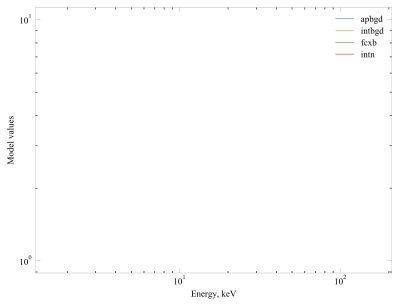

In [324]:
plot_energies = np.array(xspec.AllModels(fpma_specnum, 'intbgd').energies(1)[:-1])
f_apbgd = np.array(xspec.AllModels(fpma_specnum, 'apbgd').values(1))
f_intbgd = np.array(xspec.AllModels(fpma_specnum, 'intbgd').values(1))
f_fcxb = np.array(xspec.AllModels(fpma_specnum, 'fcxb').values(1))
f_intn = np.array(xspec.AllModels(fpma_specnum, 'intn').values(1))
plt.plot(plot_energies, f_apbgd, label='apbgd')
plt.plot(plot_energies, f_intbgd, label='intbgd')
plt.plot(plot_energies, f_fcxb, label='fcxb')
plt.plot(plot_energies, f_intn, label='intn')
plt.plot(plot_energies, f_apbgd+f_intbgd+f_fcxb+f_intn)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Energy, keV')
plt.ylabel('Model values')
plt.legend()
plt.show()
plt.close()

In [238]:
xspec.AllData.notice('**')
xspec.AllData.ignore('**-3. 20.-**')

In [337]:
def read_xspec_model_norms(spec_nums):
    """
    Make a record of the normalizations of the current XSPEC model. Only the values are saved, not parameter link information. (Note that if normalization value is set directly, the parameter link is overwritten.)
    
    Input:
    
    spec_nums -- An array of spectrum numbers (starts at 1)
    
    Output:
    
    A dictionary with the format 
    {spec_num: {
        'source_name':{
            'component1': norm1,
            'component2': norm2,
            ...},...},...}
    """
    model_norms = {}

    print('Recording current XSPEC model normalizations...')
    print('=' * 80)
    for spec_num in spec_nums:

        model_norms[spec_num] = {}
        
        for model_source in xspec.AllModels.sources.items():
            print('-' * 80)
            print('Current spectrum number, model source: ', spec_num, model_source)
            
            model_norms[spec_num][model_source[1]] = {}
            current_model = xspec.AllModels(spec_num, model_source[1])
            source_components = current_model.componentNames
            
            print('Source components: ', source_components)
            print('Listing component_name, norm: ')
            
            for component_name in source_components:
                current_norm = current_model.__getattribute__(component_name).norm.values[0]
                model_norms[spec_num][model_source[1]][component_name] = current_norm
                print(component_name, current_norm)
                
            print('-' * 80)
        print('End of spectrum number', spec_num)
        print('=' * 80)
    return model_norms

In [376]:
dir(xspec.AllModels(1, 'intbgd'))

['_AttrRestrictor__tmpRemoveRestrict',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_getFlux',
 '_getLumin',
 '_getStartParIndex',
 '_handle',
 '_resetRestrict',
 '_turnRestrictOff',
 'apec',
 'componentNames',
 'energies',
 'expression',
 'flux',
 'folded',
 'lorentz',
 'lorentz_10',
 'lorentz_11',
 'lorentz_12',
 'lorentz_13',
 'lorentz_14',
 'lorentz_15',
 'lorentz_16',
 'lorentz_17',
 'lorentz_18',
 'lorentz_19',
 'lorentz_20',
 'lorentz_21',
 'lorentz_22',
 'lorentz_23',
 'lorentz_24',
 'lorentz_25',
 'lorentz_26',
 'lorentz_27',
 'lorentz_28',
 'lorentz_29',
 'lorentz_3',
 'lorentz_30',
 'lorentz_4',
 'lorentz_5',
 'lorentz_6',
 'lorentz_7',
 'lo

In [353]:
print(xspec.AllModels(2, 'intbgd').startParIndex)
print(xspec.AllModels(2, 'intbgd').nParameters)
print(xspec.AllModels(2, 'intbgd').componentNames)

92
91
['apec', 'lorentz', 'lorentz_3', 'lorentz_4', 'lorentz_5', 'lorentz_6', 'lorentz_7', 'lorentz_8', 'lorentz_9', 'lorentz_10', 'lorentz_11', 'lorentz_12', 'lorentz_13', 'lorentz_14', 'lorentz_15', 'lorentz_16', 'lorentz_17', 'lorentz_18', 'lorentz_19', 'lorentz_20', 'lorentz_21', 'lorentz_22', 'lorentz_23', 'lorentz_24', 'lorentz_25', 'lorentz_26', 'lorentz_27', 'lorentz_28', 'lorentz_29', 'lorentz_30']


In [374]:
xspec.AllModels(2, 'intbgd').expression

'apec + lorentz + lorentz + lorentz + lorentz + lorentz + lorentz + lorentz + lorentz + lorentz + lorentz + lorentz + lorentz + lorentz + lorentz + lorentz + lorentz + lorentz + lorentz + lorentz + lorentz + lorentz + lorentz + lorentz + lorentz + lorentz + lorentz + lorentz + lorentz + lorentz'

In [380]:
xspec.AllModels(2, 'intbgd').apec.kT.values

[1.14579, -0.011457900000000002, 0.008, 0.008, 64.0, 64.0]

In [375]:
xspec.AllModels(2, 'intbgd').name

'intbgd'

In [405]:
import json

class ModelSource():
    def __init__(self, xspec_model):
        self.xsmod = xspec_model
    
    def __str__(self):
        mod = {}
        
        mod['name'] = self.xsmod.name
        mod['expression'] = self.xsmod.expression
        mod['componentNames'] = self.xsmod.componentNames
        mod['nParameters'] = self.xsmod.nParameters
        mod['startParIndex'] = self.xsmod.startParIndex
        mod['components'] = {}
        
        for component in self.xsmod.componentNames:
            mod['components'][component] = {}
            comp = self.xsmod.__getattribute__(component)
            
            mod['components'][component]['parameterNames'] = comp.parameterNames
            
            for param in comp.parameterNames:
                mod['components'][component][param] = comp.__getattribute__(param).values[0]
        
        return json.dumps(mod, indent=4)
    
    def zero_norm_pars(self):
        """
        Return a dictionary for xspec.AllModels.setPars() to update all normalization parameters 
        (those that match the name "norm") in this model to zero.
        
        Note: In Xspec, parameters for different data groups for a single model source are numbered 
        sequentially, such that if there were 12 parameters in the model, then 1-12 apply to data
        group 1, 13-24 apply to data group 2, and so on. The PyXspec model object is for one data group; 
        the total number of parameters is given by model.nParameters and the starting parameter number 
        of the data group is given by model.startParIndex. When performing parameter updates using 
        model.setPars(), the numbering always starts at 1 (do not account for preceding data groups).
        Similarly when using xspec.AllModels.setPars() parameters for each data group starts at 1.
        
        In practice, this means that the same dictionary that lists the parameter numbers to set to zero 
        can be used for all data groups of a model source, since they have the same set of parameters.
        """
        pars = {}
        
        pnum = 1
        
        for comp_name in self.xsmod.componentNames:
            param_names = self.xsmod.__getattribute__(comp_name).parameterNames
            try:
                norm_inx = param_names.index('norm')
                pars.update({
                    pnum + norm_inx: '0'
                })
            except ValueError:
                print('Expected param name "norm" not found for component %s' % comp_name)
            
            pnum += len(param_names)
            
        return pars

In [406]:
test = ModelSource(xspec.AllModels(2, 'intbgd'))

In [407]:
print(str(test))

{
    "name": "intbgd",
    "expression": "apec + lorentz + lorentz + lorentz + lorentz + lorentz + lorentz + lorentz + lorentz + lorentz + lorentz + lorentz + lorentz + lorentz + lorentz + lorentz + lorentz + lorentz + lorentz + lorentz + lorentz + lorentz + lorentz + lorentz + lorentz + lorentz + lorentz + lorentz + lorentz + lorentz",
    "componentNames": [
        "apec",
        "lorentz",
        "lorentz_3",
        "lorentz_4",
        "lorentz_5",
        "lorentz_6",
        "lorentz_7",
        "lorentz_8",
        "lorentz_9",
        "lorentz_10",
        "lorentz_11",
        "lorentz_12",
        "lorentz_13",
        "lorentz_14",
        "lorentz_15",
        "lorentz_16",
        "lorentz_17",
        "lorentz_18",
        "lorentz_19",
        "lorentz_20",
        "lorentz_21",
        "lorentz_22",
        "lorentz_23",
        "lorentz_24",
        "lorentz_25",
        "lorentz_26",
        "lorentz_27",
        "lorentz_28",
        "lorentz_29",
        "loren

In [408]:
test.zero_norm_pars()

{4: '0',
 7: '0',
 10: '0',
 13: '0',
 16: '0',
 19: '0',
 22: '0',
 25: '0',
 28: '0',
 31: '0',
 34: '0',
 37: '0',
 40: '0',
 43: '0',
 46: '0',
 49: '0',
 52: '0',
 55: '0',
 58: '0',
 61: '0',
 64: '0',
 67: '0',
 70: '0',
 73: '0',
 76: '0',
 79: '0',
 82: '0',
 85: '0',
 88: '0',
 91: '0'}

In [418]:
for _, source_name in xspec.AllModels.sources.items():
    print(source_name)

apbgd
intbgd
fcxb
intn


In [188]:
xspec.AllData.nSpectra

6

In [190]:
model_norms = read_xspec_model_norms(range(1, xspec.AllData.nSpectra + 1))
print(model_norms)

Recording current XSPEC model normalizations...
--------------------------------------------------------------------------------
Current spectrum number, model source:  1 (2, 'apbgd')
Source components:  ['cutoffpl']
Listing component_name, norm: 
cutoffpl 0.0235501
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Current spectrum number, model source:  1 (3, 'intbgd')
Source components:  ['apec', 'lorentz', 'lorentz_3', 'lorentz_4', 'lorentz_5', 'lorentz_6', 'lorentz_7', 'lorentz_8', 'lorentz_9', 'lorentz_10', 'lorentz_11', 'lorentz_12', 'lorentz_13', 'lorentz_14', 'lorentz_15', 'lorentz_16', 'lorentz_17', 'lorentz_18', 'lorentz_19', 'lorentz_20', 'lorentz_21', 'lorentz_22', 'lorentz_23', 'lorentz_24', 'lorentz_25', 'lorentz_26', 'lorentz_27', 'lorentz_28', 'lorentz_29', 'lorentz_30']
Listing component_name, norm: 
apec 0.00599441
lorentz 1.05498e-10
lorentz_3 0.000552875
l

In [204]:
def zero_xspec_model_norms(model_norms):
    """
    Iterate through sources and model components in model_norms (obtained by read_xspec_model_norms) and set all of the normalizations to zero.
    
    Note: setting the values to zero breaks any link it has to another parameter. The model thus modified should not be used for fitting.
    """
    print('Setting XSPEC model normalizations to zero...')
    print('=' * 80)
    for spec_num, sources in model_norms.items():
        for source_name, source_components in sources.items():
            print('-' * 80)
            print('Current spectrum number, model source: ', spec_num, source_name)
            current_model = xspec.AllModels(spec_num, source_name)
            for component_name, _ in source_components.items():
                current_model.__getattribute__(component_name).norm.values = 0.0
                print('Set to zero: ', component_name)
            print('-' * 80)
        print('End of FPM', fpm)
        print('=' * 80)

In [250]:
zero_xspec_model_norms(model_norms)

Setting XSPEC model normalizations to zero...
--------------------------------------------------------------------------------
Current spectrum number, model source:  1 apbgd
Set to zero:  cutoffpl
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Current spectrum number, model source:  1 intbgd
Set to zero:  apec
Set to zero:  lorentz
Set to zero:  lorentz_3
Set to zero:  lorentz_4
Set to zero:  lorentz_5
Set to zero:  lorentz_6
Set to zero:  lorentz_7
Set to zero:  lorentz_8
Set to zero:  lorentz_9
Set to zero:  lorentz_10
Set to zero:  lorentz_11
Set to zero:  lorentz_12
Set to zero:  lorentz_13
Set to zero:  lorentz_14
Set to zero:  lorentz_15
Set to zero:  lorentz_16
Set to zero:  lorentz_17
Set to zero:  lorentz_18
Set to zero:  lorentz_19
Set to zero:  lorentz_20
Set to zero:  lorentz_21
Set to zero:  lorentz_22
Set to zero:  lorentz_23
Set to zero:  lorentz_24
Set to 

Set to zero:  lorentz_3
Set to zero:  lorentz_4
Set to zero:  lorentz_5
Set to zero:  lorentz_6
Set to zero:  lorentz_7
Set to zero:  lorentz_8
Set to zero:  lorentz_9
Set to zero:  lorentz_10
Set to zero:  lorentz_11
Set to zero:  lorentz_12
Set to zero:  lorentz_13
Set to zero:  lorentz_14
Set to zero:  lorentz_15
Set to zero:  lorentz_16
Set to zero:  lorentz_17
Set to zero:  lorentz_18
Set to zero:  lorentz_19
Set to zero:  lorentz_20
Set to zero:  lorentz_21
Set to zero:  lorentz_22
Set to zero:  lorentz_23
Set to zero:  lorentz_24
Set to zero:  lorentz_25
Set to zero:  lorentz_26
Set to zero:  lorentz_27
Set to zero:  lorentz_28
Set to zero:  lorentz_29
Set to zero:  lorentz_30
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Current spectrum number, model source:  6 fcxb
Set to zero:  cutoffpl
---------------------------------------------------------------------------

## apbgd model

Two images: one for each FPM. Based on the bgdapA.fits and bgdapB.fits images. 

The spectral models were constructed using the region-sums in those images as weights to scale background regions to the reference spectra (the first spectrum for each of A and B).

To create the image model of the background, we will

- 1. For each FPM reference region: 
- 2. Perform a region-sum of the bgdap images;
- 3. Ask XSPEC for the model count rate of `apbgd` (in user-specified energy band);
- 4. Multiply the bgdap image by `model_count_rate / bgdap_region_sum`.

In [334]:
def bgimg_apbgd(bgdinfo, model_norms, bgdapweights, refspec, model_name='apbgd', ignore='**-3. 20.-**'):
    """
    Create two images, one for each module, based on the aperture images. 

    The spectral models were constructed by summing the aperture images in the background regions, and using that as the weight to scale different background regions to the reference spectra (the first spectrum for each of A and B).

    The image model of the background is created through the following steps:

    - 1. For each FPM reference region, sum the aperture images in the background regions;
    - 2. Ask XSPEC for the model predicted counts of the source `apbgd` (in user-specified energy band);
    - 3. Multiply the aperture image by `model_count_rate / bgdap_region_sum`.
    
    Inputs:
    
    bgdinfo - Object returned by model.check_bgdinfofile().
    
    model_norms - Object returned by read_xspec_model_norms().
    
    bgdapweights - Object returned by model.calc_ap_weights() containing aperture image sums on each detector, for each spectrum.
    
    refspec - A dictionary indicating the reference spectra index, e.g. {'A': 0, 'B': 1}.
    
    model_name - (Optional) Source name used in XSPEC. Default: 'apbgd'.
    
    ignore - (Optional) The XSPEC 'ignore' command to use before asking for the model predicted count rate. Default: '**-3. 20.-**'.
    
    Output:
    
    True, upon completion.
    """
    
    # Set the energy interval
    xspec.AllData.notice('**')
    xspec.AllData.ignore(ignore)
    
    for fpm in ('A', 'B'):
        output = pf.open(bgdinfo['bgdapfiles'][fpm])
        
        spec_num = 1 + refspec[fpm]
        current_model = xspec.AllModels(spec_num, model_name)
        current_spec = xspec.AllData(spec_num)
        current_norms = model_norms[spec_num][model_name]
        
        # Set model norms for the reference spectra
        component_name = 'cutoffpl'
        current_model.__getattribute__(component_name).norm.values = current_norms[component_name]
        print('Set ', component_name, current_norms[component_name])
        
        total_counts = current_spec.rate[3] * current_spec.exposure
        output[0].data *= (total_counts / bgdapweights['sum'][refspec[fpm]])
        print(total_counts)
    
        output.writeto('bgdimg_%s_%s.fits' % (model_name, fpm), overwrite=True)
    
        # Unset the model norms
        xspec.AllModels(1 + refspec[fpm], 'apbgd').cutoffpl.norm.values = 0.0
    
    return True

In [335]:
bgdapweights

{'sum': [318.29427663926583,
  155.19684635370226,
  355.8536300483623,
  340.0526915554222,
  64.70510287324805,
  151.77022744255777]}

In [336]:
bgimg_apbgd(bgdinfo, model_norms, bgdapweights, refspec, ignore='**-3. 20.-**')

Set  cutoffpl 0.0235501
882.9070471394906
Set  cutoffpl 0.0110562
406.9433234981978


True

In [262]:
for i in range(1, 7):
    print(xspec.AllData(i).rate[3] * xspec.AllData(i).exposure)

0.0
0.0
0.0
0.0
0.0
0.0


## intbgd model

The model assigns constant background values for each detector (4 detectors x 2 modules).

In the spectral model, there are optional parameter links among the spectral components, but the detector weighting (the 'ifactors' in the auxil file) are fixed. However, the different spectral components have different sets of 'ifactors' weights, so for any given region, the contributions from the detectors are different for each component.

To create the image model of the background, we will

- 1. For each FPM. 

- 2. Go through each spectral model component separately (cache the model norms, then isolate the current component and zero the others);

- 3. Ask XSPEC for the model count rate of `intbgd` (in user-specified energy band);

- 4. Distribute the model count rate based on weights `ifactor * det_area`:
    - Because the region may not cover all detectors (i.e. some `det_area` is zero), we shall calculate the flux on the detector that has the most counts and then scale it for the other detectors using their `ifactor` values.
    - `model_count_rate * ifactor_m / sum_i(ifactor_i * det_area_i)`, where `ifactor_m * det_area_m` is the largest weight, will be the pixel value of `det_m`.
    - Calculate the pixel values of the other detectors using their relative `ifactor` values.

- 5. Add the background image of the current component to the result.

In [308]:
def bgimg_intbgd(presets, refspec, bgdinfo, model_norms, bgddetweights, model_name='intbgd', ignore='**-3. 20.-**'):
    """
    The model assigns constant background values for each detector (4 detectors x 2 modules).

    In the spectral model, there are optional parameter links among the spectral components, but the detector weighting (the 'ifactors' in the auxil file) are fixed. However, the different spectral components have different sets of 'ifactors' weights, so for any given region, the contributions from the detectors are different for each component.

    The image model of the background is created through the following steps:

    - 1. For each module, go through each spectral model component separately (cache the model norms, then isolate the current component and zero the others);
    - 2. Ask XSPEC for the model count rate of `intbgd` (in user-specified energy band);
    - 3. Distribute the model count rate based on weights `ifactor * det_area`:
        - Because the region may not cover all detectors (i.e. some `det_area` is zero), we shall calculate the flux on the detector that has the most counts and then scale it for the other detectors using their `ifactor` values.
        - `model_count_rate * ifactor_m / sum_i(ifactor_i * det_area_i)`, where `ifactor_m * det_area_m` is the largest weight, will be the pixel value of `det_m`.
        - Calculate the pixel values of the other detectors using their relative `ifactor` values.
    - 4. Add the background image of the current component to the result.
    
    Inputs:
    
    presets - Preset information from auxil/ratios.json.
    
    refspec - A dictionary indicating the reference spectra index, e.g. {'A': 0, 'B': 1}.
    
    bgdinfo - Object returned by model.check_bgdinfofile().
    
    model_norms - Object returned by read_xspec_model_norms().
    
    bgddetweights - Object returned by model.calc_det_weights() containing detector image sums on each detector, for each spectrum.
    
    model_name - (Optional) Source name used in XSPEC. Default: 'intbgd'.
    
    ignore - (Optional) The XSPEC 'ignore' command to use before asking for the model predicted count rate. Default: '**-3. 20.-**'.
    
    Output:
    
    True, upon completion.
    """
    mod_intbgd = presets['models'][1]['components']
    
    # Set the energy interval
    xspec.AllData.notice('**')
    xspec.AllData.ignore(ignore)
    
    for fpm in ('A', 'B'):
        
        intbgd_values = [0.] * 4  # Tally intbgd counts / px on each detector
        
        # Use the detector with greatest area as reference for calculations
        det_areas = bgddetweights['sum'][refspec[fpm]]
        det_fracs = bgddetweights['fraction'][refspec[fpm]]
        refdet = det_areas.index(max(det_areas))
        
        spec_num = 1 + refspec[fpm]
        current_model = xspec.AllModels(spec_num, model_name)
        current_spec = xspec.AllData(spec_num)
        current_norms = model_norms[spec_num][model_name]
        
        # Check and warn about model components mismatch with presets
        if not (current_norms.keys() == mod_intbgd.keys()):
            print('Warning: the loaded XSPEC model for intbgd does not match components in preset!')
            print('Preset:')
            print(', '.join(mod_intbgd.keys()))
            print('Loaded model:')
            print(', '.join(current_norms.keys()))
        
        for component_name in mod_intbgd.keys():
            
            # Set current component to fitted norm value
            current_model.__getattribute__(component_name).norm.values = current_norms[component_name]
            print('Set ', component_name, current_norms[component_name])
            
            total_counts = current_spec.rate[3] * current_spec.exposure
        
            # Zero current component norm
            current_model.__getattribute__(component_name).norm.values = 0.0
            
            # Determine intbgd counts / px on the reference detector
            ifactors = np.array(mod_intbgd[component_name][fpm]['ifactors'])
            refdet_bgd = total_counts * ifactors[refdet] / np.sum(ifactors * det_areas)
            
            # Use ifactors to scale to all detectors
            for i in range(4):
                intbgd_values[i] += refdet_bgd * ifactors[i] / ifactors[refdet]
        
        # Multiply detector images by their intbgd_values[i] and create composite image
        output = pf.open(bgdinfo['refimgf'])
        output[0].data *= 0.0
        
        for i in range(4):
            output[0].data += bgddetim[fpm][i] * intbgd_values[i]
        
        output.writeto('bgdimg_%s_%s.fits' % (model_name, fpm), overwrite=True)
    
    return True

In [309]:
for i in range(1, 7):
    print(xspec.AllData(i).rate[3] * xspec.AllData(i).exposure)

0.0
0.0
0.0
0.0
0.0
0.0


In [310]:
bgimg_intbgd(presets, refspec, bgdinfo, model_norms, bgddetweights, ignore='**-3. 20.-**')

Set  apec 0.00599441
Set  lorentz 1.05498e-10
Set  lorentz_3 0.000552875
Set  lorentz_4 0.000257078
Set  lorentz_5 2.9842e-05
Set  lorentz_6 0.00013527557652
Set  lorentz_7 0.000112849999886
Set  lorentz_8 0.0012001631745
Set  lorentz_9 0.00021583050432199999
Set  lorentz_10 7.187386015999999e-21
Set  lorentz_11 0.0013237693353400002
Set  lorentz_12 0.0006467931206399999
Set  lorentz_13 0.0005239091362
Set  lorentz_14 0.0010610806540400002
Set  lorentz_15 0.0004660454982
Set  lorentz_16 0.000234863373818
Set  lorentz_17 0.00194696758026
Set  lorentz_18 0.00021228551345799999
Set  lorentz_19 0.00122827493534
Set  lorentz_20 0.00051803294798
Set  lorentz_21 0.00057741017222
Set  lorentz_22 0.00122793652706
Set  lorentz_23 0.000160567596622
Set  lorentz_24 0.00100224625578
Set  lorentz_25 0.00156221736004
Set  lorentz_26 0.00052949346966
Set  lorentz_27 0.00041662953356
Set  lorentz_28 0.000152952723956
Set  lorentz_29 7.6968695294e-05
Set  lorentz_30 0.00083378577842
Set  apec 3.44957e-0

True

## fcxb model

All of the regions have their own flux values.

To create the image model of the background, we will

- 1. For each spectrum:

- 2. Ask XSPEC for the model count rate of `fcxb` (in user-specified energy band);

- 3. Calculate the flux as `model_count_rate / n_pixel`.

- 4. Fill the detector mask pixels in this spectral region with this flux value, add it to the output image;
    - Add 1 to a second temporary image array in this spectral region;

- 5. After all spectral regions have been processed, for each FPM, divide the output image by the temporary image (accounts for overlapping regions).

In [331]:
def bgimg_fcxb(bgdinfo, model_norms, bgddetweights, regmask, model_name='fcxb', ignore='**-3. 20.-**'):
    """
    All of the regions are allowed to have their own flux values.

    The image model of the background is created through the following steps:

    - 1. For each spectrum, ask XSPEC for the model count rate of `fcxb` (in user-specified energy band);
    - 2. Calculate the flux as `model_count_rate / n_pixel`.
    - 3. Fill the detector mask pixels in this spectral region with this flux value, output an image for this region;
    - 4. After all spectral regions have been processed, create an image for each module based on the fluxes in all of the background regions.
    
    The last step above currently produces an image assuming a constant background over the field of view. Users may make use of the images of individual regions to create their own models of this.
    
    Inputs:
    
    bgdinfo - Object returned by model.check_bgdinfofile().
    
    model_norms - Object returned by read_xspec_model_norms().
    
    bgddetweights - Object returned by model.calc_det_weights() containing detector image sums on each detector, for each spectrum.
    
    regmask - Image masks for the spectral regions returned by util.mask_from_region().
    
    model_name - (Optional) Source name used in XSPEC. Default: 'fcxb'.
    
    ignore - (Optional) The XSPEC 'ignore' command to use before asking for the model predicted count rate. Default: '**-3. 20.-**'.
    
    Output:
    
    True, upon completion.
    """
    fpmlist = [util.fpm_parse(_) for _ in numodel.get_keyword_xspecdata('INSTRUME')]
    
    # Set the energy interval
    xspec.AllData.notice('**')
    xspec.AllData.ignore(ignore)
        
    # Track simple mean flux
    overall_counts = 0.
    overall_area = 0.
    
    for i_spec in range(xspec.AllData.nSpectra):
        
        fpm = fpmlist[i_spec]
        
        # Use the detector with greatest area as reference for calculations
        det_areas = bgddetweights['sum'][i_spec]

        spec_num = 1 + i_spec
        current_model = xspec.AllModels(spec_num, model_name)
        current_spec = xspec.AllData(spec_num)
        current_norms = model_norms[spec_num][model_name]
        

        # Set current component to fitted norm value
        component_name = 'cutoffpl'
        current_model.__getattribute__(component_name).norm.values = current_norms[component_name]
        print('Set ', component_name, current_norms[component_name])

        total_counts = current_spec.rate[3] * current_spec.exposure
        overall_counts += total_counts
        print(total_counts)

        # Zero current component norm
        current_model.__getattribute__(component_name).norm.values = 0.0

        # Determine fcxb counts / px
        total_area = np.sum(det_areas)
        overall_area += total_area
        fcxb_flux = total_counts / total_area

        output = pf.open(bgdinfo['refimgf'])
        output[0].data *= 0.0
        
        for i_det in range(4):
            output[0].data += bgddetim[fpm][i_det] * fcxb_flux
        
        output[0].data *= regmask[i_spec]
        
        output.writeto('bgdimg_fcxb_%d.fits' % (1 + i_spec), overwrite=True)
    
    
    # Create detector images filled by mean flux across all spectral regions (overlapping areas are treated as independent)
    overall_flux = overall_counts / overall_area
    for fpm in ('A', 'B'):
        output = pf.open(bgdinfo['refimgf'])
        output[0].data *= 0.0
        for i_det in range(4):
            output[0].data += bgddetim[fpm][i_det] * overall_flux / 2.
        output.writeto('bgdimg_%s_%s.fits' % (model_name, fpm), overwrite=True)

    return True

In [332]:
for i in range(1, 7):
    print(xspec.AllData(i).rate[3] * xspec.AllData(i).exposure)

0.0
0.0
0.0
0.0
0.0
0.0


In [333]:
bgimg_fcxb(bgdinfo, model_norms, bgddetweights, regmask, model_name='fcxb', ignore='**-3. 20.-**')

Set  cutoffpl 1.62213e-05
147.93915948043139
Set  cutoffpl 1.50342e-05
134.11701044420565
Set  cutoffpl 1.62854227989e-05
150.52045039701554
Set  cutoffpl 1.53447614694e-05
139.68381131893582
Set  cutoffpl 9.79221646533e-06
85.9313063441228
Set  cutoffpl 9.02289841044e-06
80.92131145080646


True

## intn model

The model uses a single component, a broken power law.

There are only two free normalizations, one for each FPM. Relative weights of detectors are fixed by preset values of `ifactors`. Very similar process to `intbgd` except we need only look at one component per FPM.

To create the image model of the background, we will

- 1. For each FPM, ask XSPEC for the model count rate of `intbgd` (in user-specified energy band);

- 2. Distribute the model count rate based on weights `ifactor * det_area`:
    - Because the region may not cover all detectors (i.e. some `det_area` is zero), we shall calculate the flux on the detector that has the most counts and then scale it for the other detectors using their `ifactor` values.
    - `model_count_rate * ifactor_m / sum_i(ifactor_i * det_area_i)`, where `ifactor_m * det_area_m` is the largest weight, will be the pixel value of `det_m`.
    - Calculate the pixel values of the other detectors using their relative `ifactor` values.

In [303]:
def bgimg_intn(presets, refspec, bgdinfo, model_norms, bgddetweights, model_name='intn', ignore='**-3. 20.-**'):
    """
    The model uses a single component, a broken power law.

    There are only two free normalizations, one for each module. Relative weights of detectors are fixed by preset values of `ifactors`. The model image is created through an identical process to `intbgd` except we need only look at one model component.
    
    Inputs:
    
    presets - Preset information from auxil/ratios.json.
    
    refspec - A dictionary indicating the reference spectra index, e.g. {'A': 0, 'B': 1}.
    
    bgdinfo - Object returned by model.check_bgdinfofile().
    
    model_norms - Object returned by read_xspec_model_norms().
    
    bgddetweights - Object returned by model.calc_det_weights() containing detector image sums on each detector, for each spectrum.
    
    model_name - (Optional) Source name used in XSPEC. Default: 'intn'.
    
    ignore - (Optional) The XSPEC 'ignore' command to use before asking for the model predicted count rate. Default: '**-3. 20.-**'.
    
    Output:
    
    True, upon completion.
    """
    mod_intn = presets['models'][3]['components']
    
    # Set the energy interval
    xspec.AllData.notice('**')
    xspec.AllData.ignore(ignore)
    
    for fpm in ('A', 'B'):
        
        intbgd_values = [0.] * 4  # Tally intbgd counts / px on each detector
        
        # Use the detector with greatest area as reference for calculations
        det_areas = bgddetweights['sum'][refspec[fpm]]
        det_fracs = bgddetweights['fraction'][refspec[fpm]]
        refdet = det_areas.index(max(det_areas))
        
        spec_num = 1 + refspec[fpm]
        current_model = xspec.AllModels(spec_num, model_name)
        current_spec = xspec.AllData(spec_num)
        current_norms = model_norms[spec_num][model_name]
        
        # Check and warn about model components mismatch with presets
        if not (current_norms.keys() == mod_intn.keys()):
            print('Warning: the loaded XSPEC model for intn does not match components in preset!')
            print('Preset:')
            print(', '.join(mod_intn.keys()))
            print('Loaded model:')
            print(', '.join(current_norms.keys()))
        
        for component_name in mod_intn.keys():
            
            # Set current component to fitted norm value
            current_model.__getattribute__(component_name).norm.values = current_norms[component_name]
            print('Set ', component_name, current_norms[component_name])
            
            total_counts = current_spec.rate[3] * current_spec.exposure
        
            # Zero current component norm
            current_model.__getattribute__(component_name).norm.values = 0.0
            
            # Determine intbgd counts / px on the reference detector
            ifactors = np.array(mod_intn[component_name][fpm]['ifactors'])
            refdet_bgd = total_counts * ifactors[refdet] / np.sum(ifactors * det_areas)
            
            # Use ifactors to scale to all detectors
            for i in range(4):
                intbgd_values[i] += refdet_bgd * ifactors[i] / ifactors[refdet]
        
        # Multiply detector images by their intbgd_values[i] and create composite image
        output = pf.open(bgdinfo['refimgf'])
        output[0].data *= 0.0
        
        for i in range(4):
            det_img = pf.open(bgdinfo['bgddetfiles'][fpm][i])[0].data
            output[0].data += det_img * intbgd_values[i]
        
        output.writeto('bgdimg_%s_%s.fits' % (model_name, fpm), overwrite=True)
    
    return True

In [304]:
for i in range(1, 7):
    print(xspec.AllData(i).rate[3] * xspec.AllData(i).exposure)

0.0
0.0
0.0
0.0
0.0
0.0


In [305]:
bgimg_intn(presets, refspec, bgdinfo, model_norms, bgddetweights, ignore='**-3. 20.-**')

Set  bknpower 0.000200682
Set  bknpower 0.00019487


True

In [338]:
'%.2f' % float(3)

'3.00'

In [341]:
xspec.AllData.notice('**')
xspec.AllData.ignore('**-3.0 20.0-**')